# Hands on keras, *one ring to rule'em all!*
In this notebook, we'll see how to fit a convnet on (not)MNIST data using keras, with theano backend.

**Load the notMNIST train / test data prepared from <a href="https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/udacity/1_notmnist.ipynb">1_notmnist.ipynb notebook</a> (Google / Udacity assignment 1)**

In [50]:
import pickle
import numpy as np
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    train_labels = save['train_labels']
    valid_dataset = save['valid_dataset']
    valid_labels = save['valid_labels']
    test_dataset = save['test_dataset']
    test_labels = save['test_labels']
    del save  # hint to help gc free up memory
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)


('Training set', (200000, 1, 28, 28), (200000, 10))
('Validation set', (10000, 1, 28, 28), (10000, 10))
('Test set', (10000, 1, 28, 28), (10000, 10))


**Reshape the data**

In [ ]:
image_size = 28
nb_class = 10

def reformat(dataset, labels):
    dataset = dataset.reshape((-1, 1, image_size, image_size)).astype(np.float32)
    # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

**Import stuff from keras**

In [8]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.utils import visualize_util as vizu

**Basic parameters for the overall DNN structure**

In [109]:
batch_size = 128
nb_epoch = 3  # number of passes to make on the data
nb_filter = 32
pool_size = 2  # size of max-pooling filter
conv_size = 3  # width of convolution filter

**Contruct the DNN proper**

In [119]:
# We'll stack different layers in a sequence
dnn = Sequential()

# The 1st layer is convolutional layer with ReLu activation, to extract useful features using patches
# of size conv_size x conv_size
dnn.add(Convolution2D(nb_filter, conv_size, conv_size, border_mode='valid',
                      input_shape=(1, image_size, image_size), activation="relu"))

# The 2nd layer does a max-pooling op on patches of size pool_size x pool_size
dnn.add(MaxPooling2D(pool_size=(pool_size, pool_size)))

# Collapse everything
dnn.add(Flatten())
dnn.add(Dense(output_dim=nb_class))

# Use softmax as output layer
dnn.add(Activation("softmax"))

# Plot and dump the network design onto disk
vizu.plot(dnn, "mnist_dnn.png")

<img src="mnist_dnn.png">

**Compile and fit the DNN model (this may take a while...)**

In [ ]:
dnn.compile(optimizer="adadelta", loss="categorical_crossentropy")
dnn.fit(train_dataset, train_labels, nb_epoch=nb_epoch, batch_size=batch_size,
        validation_data=(valid_dataset, valid_labels))

Train on 200000 samples, validate on 10000 samples
Epoch 1/3
127616/200000 [==================>...........] - ETA: 43s - loss: 0.4088

**Finally, evaluate the fitted model on test data**

In [115]:
score = dnn.evaluate(test_dataset, test_labels, show_accuracy=True, verbose=0)
print('Test accuracy (on %i samples): %.2f%%' % (len(test_dataset), score[1] * 100))

Test accuracy (on 10000 samples): 94.51%


**Always a good idea to save hard-earned model weights**

In [55]:
dnn.save_weights('mnist_dnn.hdf5', overwrite=True)

**Visualization of model weights (code adapted from <a href="https://github.com/julienr/ipynb_playground/blob/master/keras/convmnist/keras_cnn_mnist.ipynb">here</a>)**

In [92]:
import numpy.ma as ma
import matplotlib.pyplot as plt
%matplotlib inline


def make_mosaic(imgs, nrows, ncols, border=1):
    """
    Given a set of images with all the same shape, makes a
    mosaic with nrows and ncols.
    
    Usage: plt.imshow(make_mosaic(np.random.random((12, 10, 10)), 3, 4, border=1))
    """
    nimgs = imgs.shape[0]
    imshape = imgs.shape[1:]
    mosaic = ma.masked_all((nrows * imshape[0] + (nrows - 1) * border,
                            ncols * imshape[1] + (ncols - 1) * border),
                            dtype=np.float32)
    paddedh = imshape[0] + border
    paddedw = imshape[1] + border
    for i in xrange(nimgs):
        row = int(np.floor(i / ncols))
        col = i % ncols
        mosaic[row * paddedh:row * paddedh + imshape[0],
               col * paddedw:col * paddedw + imshape[1]] = imgs[i]
    return mosaic

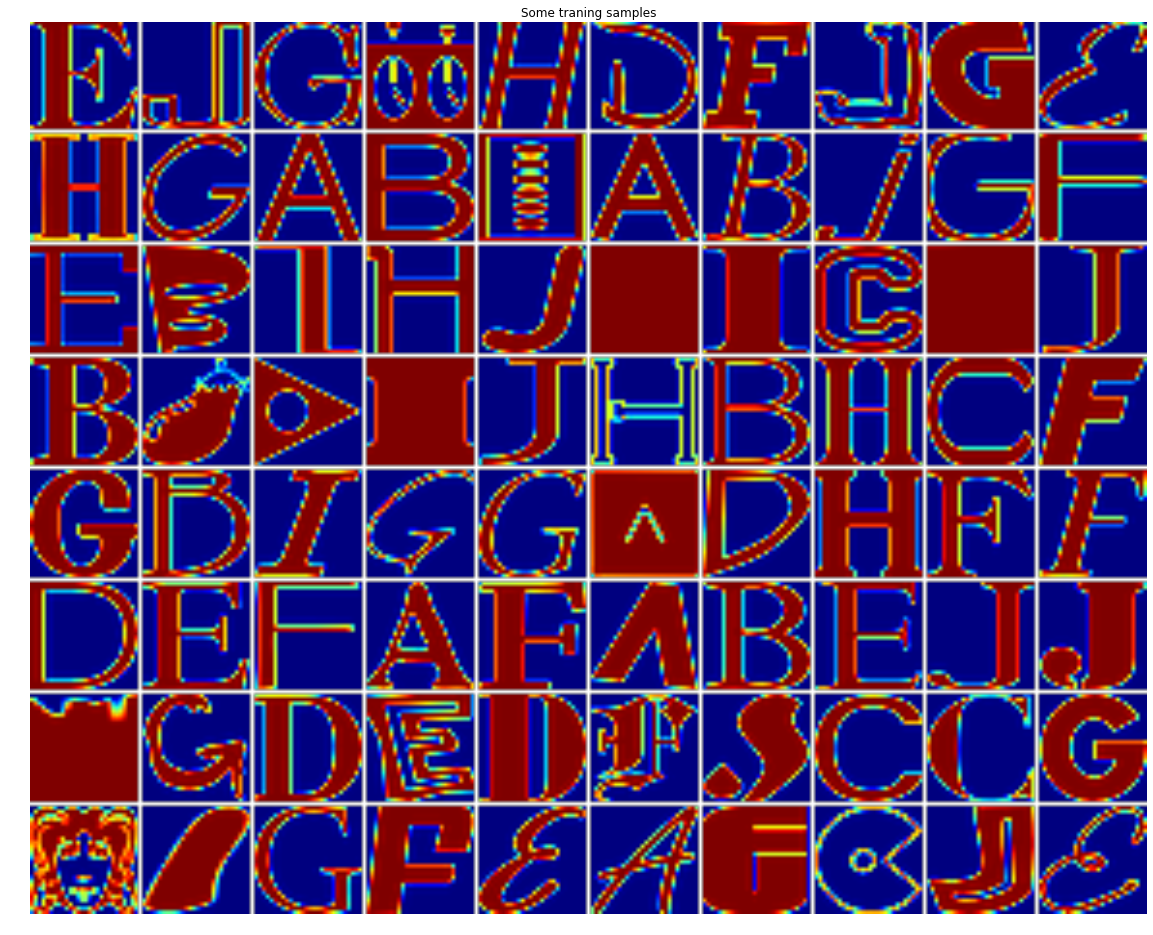

In [123]:
plt.figure(figsize=(20, 16))
plt.title("Some traning samples")
plt.imshow(make_mosaic(train_dataset[:80, 0], 8, 10, border=1));
plt.axis("off");

In [95]:
weights = dnn.layers[0].W.get_value(borrow=True)
weights = np.squeeze(weights)
print("W shape: %s" % str(weights.shape))

W shape: (32, 5, 5)


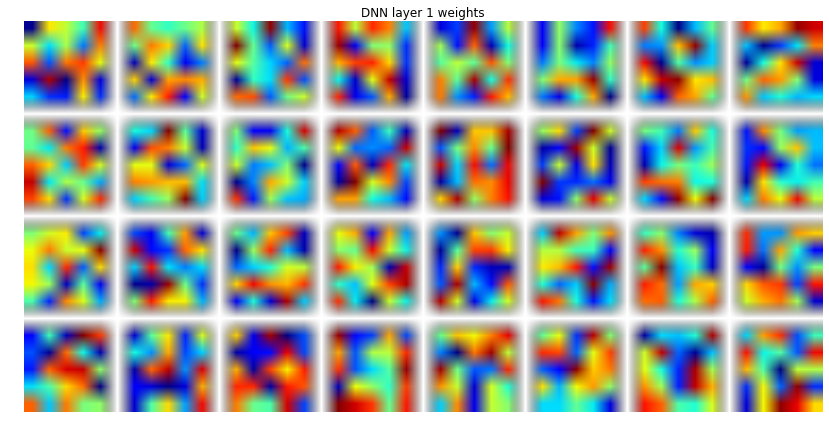

In [91]:
plt.figure(figsize=(16, 10))
plt.title("DNN layer 1 weights")
plt.imshow(make_mosaic(weights, 4, 8, border=1));
plt.axis("off");